In [1]:
import numpy as np
import cv2
import numpy as np
import cv2
import os
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.widgets import RectangleSelector
import math

In [2]:
np.random.seed(42)

n_components = 10

mat_files = sorted([file for file in os.listdir("data_np/") if file.endswith('.npy')])
idx = 2

image_sequence = np.load('data_np/' + mat_files[idx])
image_sequence = image_sequence[135:, :, :]
roi_coords = []

In [3]:
print(mat_files[idx])

20s_long_heating_refl_50Hz_15J_Tamb_2.npy


Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


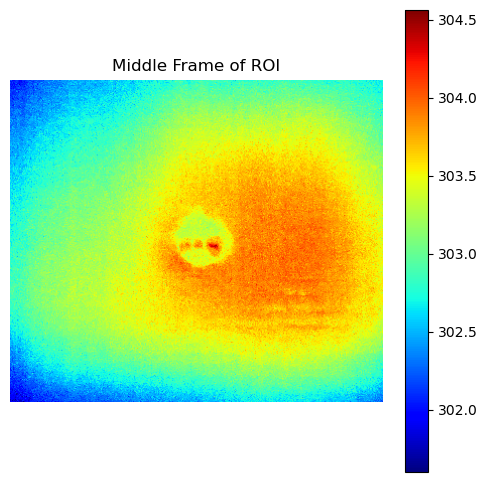

In [4]:
h, w, t = image_sequence.shape

middle_frame = image_sequence[:, :, t // 2]
frame_8bit = cv2.normalize(middle_frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
colored = cv2.applyColorMap(frame_8bit, cv2.COLORMAP_JET)

roi = cv2.selectROI("Select ROI", colored, showCrosshair=True)
cv2.destroyAllWindows()

x, y, w_roi, h_roi = roi
image_sequence = image_sequence[y:y+h_roi, x:x+w_roi, :]

t = image_sequence.shape[2]
middle_frame = image_sequence[:, :, t // 2]

plt.figure(figsize=(6, 6))
plt.imshow(middle_frame, cmap='jet')
plt.title('Middle Frame of ROI')
plt.axis('off')
plt.colorbar()
plt.show()

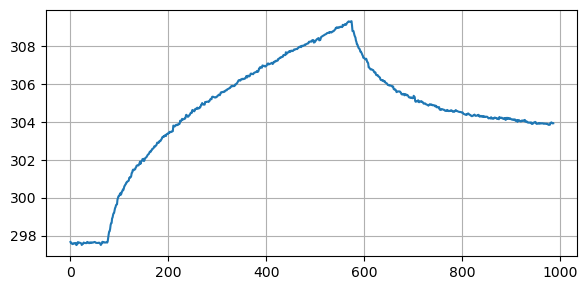

222


In [5]:
h, w, sequence_size = image_sequence.shape
plt.figure(figsize=(6, 3))
plt.plot(image_sequence.reshape(h * w, sequence_size)[5000,13:1000])
plt.grid(True)
plt.tight_layout()
plt.show()

diff = np.diff(image_sequence.reshape(h * w, sequence_size)[5000,:1000])
t_pulse = np.argmax(diff)
print(t_pulse)
t_pulse = 80

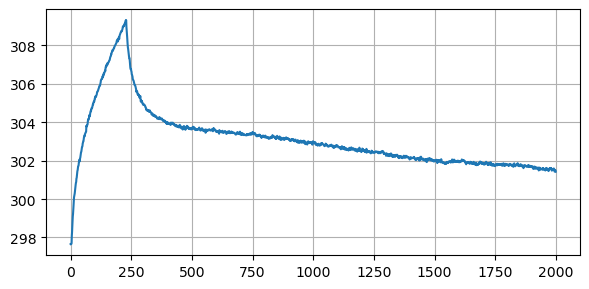

In [6]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

h, w, sequence_size = image_sequence.shape
imageMatrix = image_sequence.reshape(h * w, sequence_size)
imageMatrix = imageMatrix[:, t_pulse:]

original_len = imageMatrix.shape[1]
target_len = 2000

x_old = np.linspace(0, 1, original_len)
x_new = np.linspace(0, 1, target_len)

f = interp1d(x_old, imageMatrix, kind="linear", axis=1)
imageMatrix = f(x_new)

plt.figure(figsize=(6, 3))
plt.plot(imageMatrix[5000, :])
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
imageMatrix = imageMatrix - np.mean(imageMatrix, axis=1, keepdims=True)

U, S, Vh = np.linalg.svd(imageMatrix, full_matrices=False)

Vh = Vh[:n_components, :]

principal_comp = np.matmul(imageMatrix, Vh.T)

pca_array = principal_comp.reshape(h, w, n_components)
pca_array = pca_array.transpose(2, 0, 1)

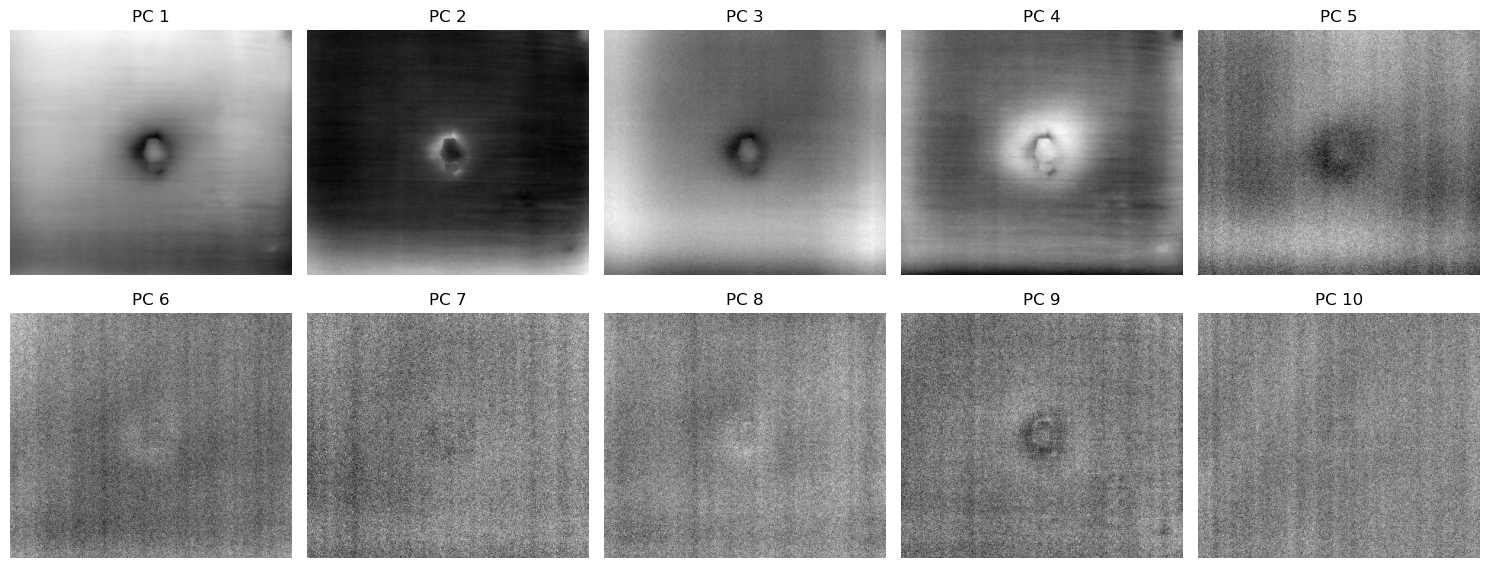

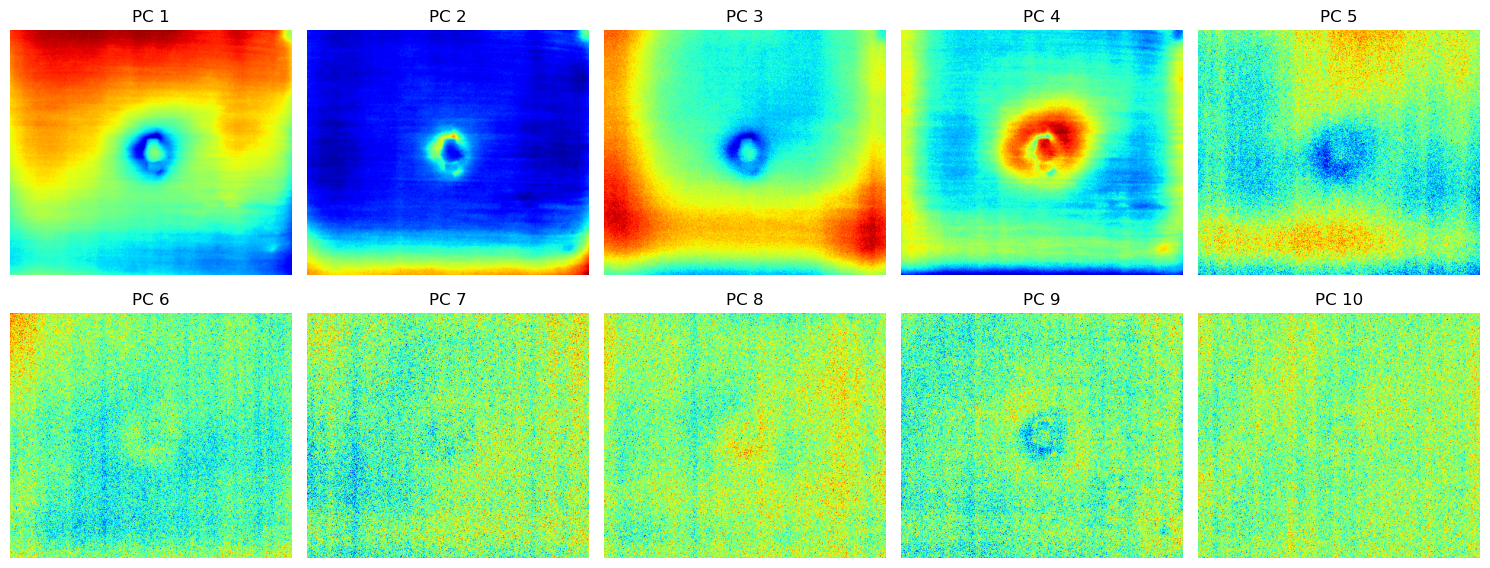

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='jet')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

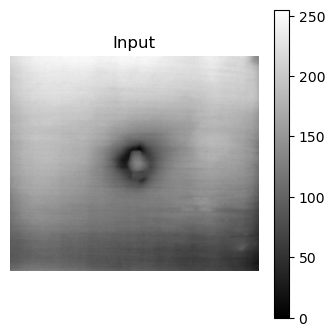

In [9]:
import torch
import cv2
import numpy as np
import os

comp = pca_array[0, :, :]

comp -= comp.min()
comp /= (comp.max() + 1e-8)
comp = (comp * 255).astype(np.uint8)

gray_8u = cv2.normalize(comp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
bgr = cv2.applyColorMap(gray_8u, cv2.COLORMAP_JET)
img_rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
img_rgb = cv2.cvtColor(gray_8u, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(4, 4))
plt.imshow(img_rgb, cmap='gray')
plt.title(f'Input')
plt.axis('off')
plt.colorbar()
plt.show()

In [10]:
from PIL import Image, ImageDraw

image = Image.fromarray(img_rgb).convert("RGB")
W, H = image.size

save_path = "temp_image.jpg"
image.save(save_path)

In [11]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch, re
from PIL import Image

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-VL-7B-Instruct", trust_remote_code=True)
model = Qwen2VLForConditionalGeneration.from_pretrained("Qwen/Qwen2-VL-7B-Instruct", torch_dtype="auto", device_map="auto")
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")
model.eval()

/home/m123/anaconda3/envs/grit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading 

Qwen2VLForConditionalGeneration(
  (model): Qwen2VLModel(
    (visual): Qwen2VisionTransformerPretrainedModel(
      (patch_embed): PatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2VLVisionBlock(
          (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
          (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
          (attn): VisionAttention(
            (qkv): Linear(in_features=1280, out_features=3840, bias=True)
            (proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (mlp): VisionMlp(
            (fc1): Linear(in_features=1280, out_features=5120, bias=True)
            (act): QuickGELUActivation()
            (fc2): Linear(in_features=5120, out_features=1280, bias=True)
          )
        )
      )
      (merger): PatchMerger(
        (ln_q): LayerN

In [12]:
messages = [
    {
        "role": "system",
        "content": (
            "You are an expert NDT inspection assistant. "
            "Task: Inspect the thermal image and detect defects and describe their location. "
            "1) Output format must be <ref>defect</ref><box>(x1,y1),(x2,y2)</box>. "
            "2) Use integer pixel coordinates for the thermal image; (x1,y1) is top-left, (x2,y2) is bottom-right, and x2>x1, y2>y1. "
            "3) If uncertain, output <ref>none</ref><box>(0,0),(0,0)</box>. "
            "4) No extra text."
        )
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "image": f"file://{save_path}"},
            {"type": "text", "text": "Inspect the thermal image and detect defects and return only the defect location."}
        ]
    }
]

In [13]:
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

In [14]:
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['<ref>dark spot</ref><box>(437,414), (562,594)</box>']


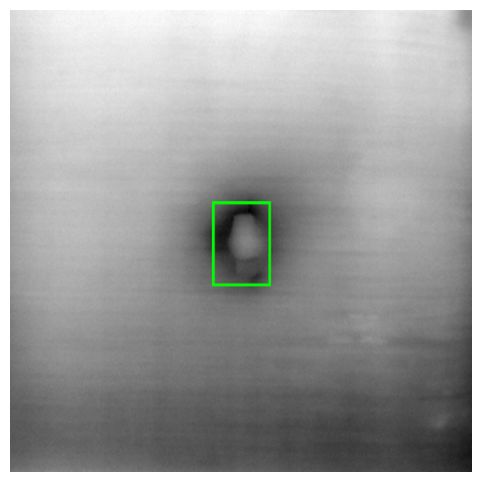

In [ ]:
import re
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt

result_text = output_text[0]

pattern = r"<ref>(.*?)</ref>\s*<box>\(\s*(\d+)\s*,\s*(\d+)\s*\),\s*\(\s*(\d+)\s*,\s*(\d+)\s*\)</box>"
match = re.search(pattern, result_text)

if not match:
    print("No match found.")
else:
    label, x1, y1, x2, y2 = match.groups()
    x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))

    w, h = image.size
    scale_x = w / 1000.0
    scale_y = h / 1000.0
    x1 = int(round(x1 * scale_x))
    x2 = int(round(x2 * scale_x))
    y1 = int(round(y1 * scale_y))
    y2 = int(round(y2 * scale_y))

    draw = ImageDraw.Draw(image)
    draw.rectangle([(x1, y1), (x2, y2)], outline="lime", width=2)

    try:
        font = ImageFont.truetype("arial.ttf", 16)
    except:
        font = ImageFont.load_default()

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.show()